In [1]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
files = glob('kaggle/*/*/*')
len(files)

276397

In [3]:
# major imbalance in the data
count = 0
for file in files:
    if file[-5] == '1':
        count += 1
print(count)

78676


In [4]:
# displays 25 random images in all of the data
def show_img(files):
    plt.figure(figsize= (10,10))
    ind = np.random.randint(0, len(files), 25)
    i=0
    for loc in ind:
        plt.subplot(5,5,i+1)
        sample = load_img(files[loc], target_size=(150,150))
        sample = img_to_array(sample)
        plt.axis("off")
        plt.imshow(sample.astype("uint8"))
        i+=1

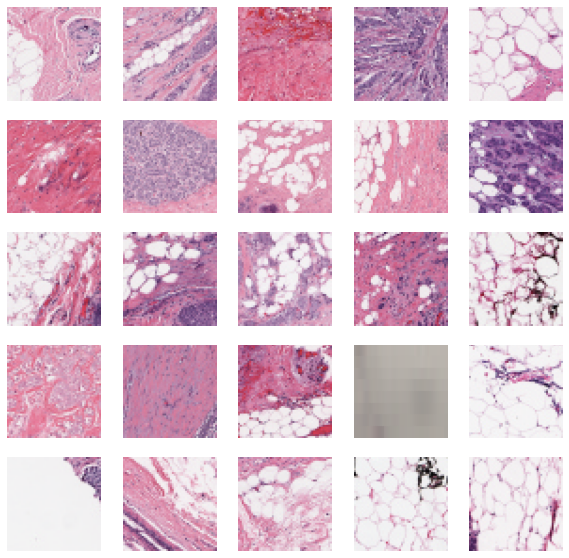

In [5]:
show_img(files)

In [6]:
# load all of the data as (PIL Image, int)
def load_data(files, lower_limit, upper_limit):
    X = []
    y = []
    ind = 0
    for file in files[lower_limit:upper_limit]:
        if file.endswith(".png"):
            img = load_img(file, target_size = (50,50))
            pixels = img_to_array(img)
            pixels /= 255
            X.append(pixels)
            if(file[-5] == '1'):
                y.append(1)
            elif(file[-5] == '0'):
                y.append(0)
        if ind % 1000 == 0:
            print('element:', ind)
        ind += 1
    # np.stack is essentially a way of joining arrays
    return np.stack(X), y

In [7]:
'''
# training data
X_train,y_train = load_data(files,0, 90000)

# validation data
X_test, y_test = load_data(files, 90000, 110000)
'''

'\n# training data\nX_train,y_train = load_data(files,0, 90000)\n\n# validation data\nX_test, y_test = load_data(files, 90000, 110000)\n'

In [8]:
'''
# plots the values of y
import seaborn as sns

sns.countplot(y_train)
sns.countplot(y_test)
'''

'\n# plots the values of y\nimport seaborn as sns\n\nsns.countplot(y_train)\nsns.countplot(y_test)\n'

Dealing with Class Imbalance Problem

In [9]:
# loading the data but in a balanced way
def load_balanced_data(files, size, start_index):
    half_size = int(size/2)
    count=0
    res = []
    y = []
    # appending all the values with 1 first
    for file in files[start_index:]:
        if (count!=half_size):
            if file[-5] == '1' and file.endswith(".png"):
                img = load_img(file, target_size = (50,50))
                pixels = img_to_array(img)
                pixels /= 255
                res.append(pixels)
                y.append(1)
                count += 1

    # appending all of the values with 0
    for file in files[start_index:]:
        if(count!=0):
            if(file[-5] == '0'):
                img = load_img(file, target_size = (50,50))
                pixels = img_to_array(img)
                pixels /= 255
                res.append(pixels)
                y.append(0)
                count -= 1
    return np.stack(res), y

In [10]:
# loading the training data but balanced
X_train2, y_train2 = load_balanced_data(files, 90000,0)
X_test2, y_test2 = load_balanced_data(files, 20000, 150000)

/Users/rayaq/Desktop/AI Projects 2022/breast_histopathology_detection/breast/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/rayaq/Desktop/AI Projects 2022/breast_histopathology_detection/breast/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

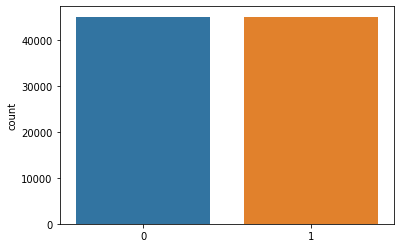

In [11]:
import seaborn as sns

sns.countplot(y_train2)
sns.countplot(y_test2)

In [12]:
# creating our model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

# old model as a function defition
def CNN(inp_shape=(50,50,3)):
    # model
    inp = Input(inp_shape)

    m = Conv2D(32, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(inp)
    m = MaxPooling2D(2)(m)
    m = BatchNormalization()(m)

    m = Conv2D(64, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = BatchNormalization()(m)

    m = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = BatchNormalization()(m)

    m = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = Flatten()(m)

    m = Dense(128, activation='relu')(m)
    out = Dense(1, activation='sigmoid')(m)

    model = Model(inp, out)
    model.compile(optimizer = tf.keras.optimizers.SGD(1e-3, momentum=0.9), loss="binary_crossentropy", metrics = ['acc'])
    return model

# class CNN(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
#
#     def call(self, input, training=False):
#         pass

In [13]:
model = CNN()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 25, 25, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0     

2022-02-13 16:14:27.789778: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
X_train2 = np.array(X_train2)
X_test2 = np.array(X_test2)
y_train2 = np.array(y_train2)
y_test2 = np.array(y_test2)

In [16]:
history = model.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), epochs = 15, batch_size=256)

Epoch 1/15
352/352 [==============================] - 104s 293ms/step - loss: 0.4390 - acc: 0.8037 - val_loss: 0.4869 - val_acc: 0.7631
Epoch 2/15
352/352 [==============================] - 104s 295ms/step - loss: 0.3769 - acc: 0.8372 - val_loss: 0.4385 - val_acc: 0.7968
Epoch 3/15
352/352 [==============================] - 104s 296ms/step - loss: 0.3587 - acc: 0.8457 - val_loss: 0.4290 - val_acc: 0.8106
Epoch 4/15
352/352 [==============================] - 109s 311ms/step - loss: 0.3505 - acc: 0.8490 - val_loss: 0.4150 - val_acc: 0.8195
Epoch 5/15
352/352 [==============================] - 111s 317ms/step - loss: 0.3413 - acc: 0.8536 - val_loss: 0.4289 - val_acc: 0.8146
Epoch 6/15
352/352 [==============================] - 106s 301ms/step - loss: 0.3343 - acc: 0.8578 - val_loss: 0.4172 - val_acc: 0.8180
Epoch 7/15
352/352 [==============================] - 110s 311ms/step - loss: 0.3264 - acc: 0.8613 - val_loss: 0.4358 - val_acc: 0.8054
Epoch 8/15
352/352 [============================

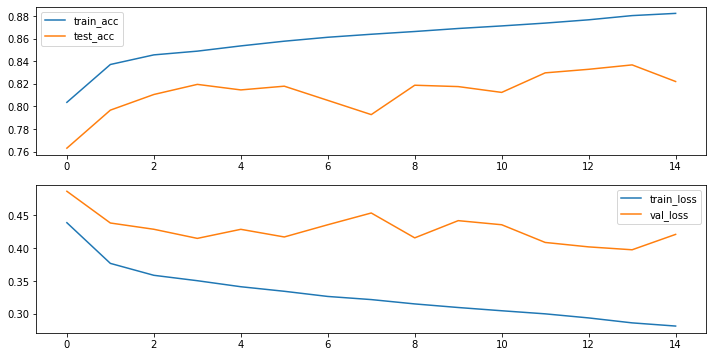

In [18]:
#plot the accuracy graph
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history.history['acc'], label="train_acc")
plt.plot(history.history['val_acc'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()

In [27]:
class CNN_Dropout(tf.keras.Model):

    def __init__(self, inp_shape=(50, 50, 3)):
        super().__init__()
        self.conv1 = Conv2D(32, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')
        self.max1 = MaxPooling2D(2)
        self.conv2 = Conv2D(64, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')
        self.max2 = MaxPooling2D(2)
        self.conv3 = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')
        self.max3 = MaxPooling2D(2)
        self.conv4 = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')
        self.max4 = MaxPooling2D(2)
        self.conv5 = Conv2D(256, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')
        self.max5 = MaxPooling2D(2)
        self.dropout = Dropout(0.2)
        self.flattten = Flatten()
        self.dense1 = Dense(128, activation = 'relu')
        self.dense2 = Dense(1, activation ='sigmoid')

    def call(self, x):
        x = self.conv1(x)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)
        x = self.conv4(x)
        x = self.max4(x)
        x = self.conv5(x)
        x = self.max5(x)
        x = self.dropout(x)
        x = self.flattten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [28]:
model_dropout = CNN_Dropout()
model_dropout.compile(optimizer = tf.keras.optimizers.SGD(1e-3, momentum=0.9), loss="binary_crossentropy", metrics = ['acc'])

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2
)

In [25]:
train_generator = datagen.flow(X_train2, y_train2, batch_size=256)
val_generator = datagen.flow(X_test2, y_test2, batch_size=256)

In [29]:
history2 = model_dropout.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15
352/352 [==============================] - 123s 348ms/step - loss: 0.5658 - acc: 0.7204 - val_loss: 0.4760 - val_acc: 0.7879
Epoch 2/15
352/352 [==============================] - 129s 366ms/step - loss: 0.4932 - acc: 0.7764 - val_loss: 0.4629 - val_acc: 0.7886
Epoch 3/15
352/352 [==============================] - 120s 340ms/step - loss: 0.4787 - acc: 0.7848 - val_loss: 0.4723 - val_acc: 0.7841
Epoch 4/15
352/352 [==============================] - 123s 349ms/step - loss: 0.4659 - acc: 0.7910 - val_loss: 0.4943 - val_acc: 0.7815
Epoch 5/15
352/352 [==============================] - 123s 350ms/step - loss: 0.4617 - acc: 0.7917 - val_loss: 0.4934 - val_acc: 0.7678
Epoch 6/15
352/352 [==============================] - 125s 354ms/step - loss: 0.4494 - acc: 0.7990 - val_loss: 0.4493 - val_acc: 0.7969
Epoch 7/15
352/352 [==============================] - 124s 352ms/step - loss: 0.4462 - acc: 0.8006 - val_loss: 0.4482 - val_acc: 0.7975
Epoch 8/15
352/352 [============================

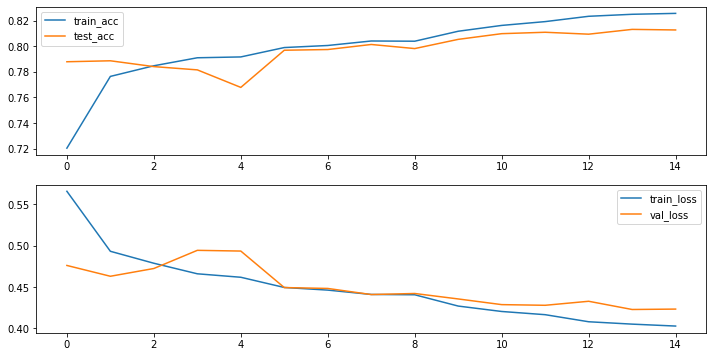

In [30]:
#plot accuracy and loss graph
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history2.history['acc'], label="train_acc")
plt.plot(history2.history['val_acc'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history2.history['loss'], label = "train_loss")
plt.plot(history2.history['val_loss'], label = "val_loss")
plt.legend()

[[7321 2679]
 [ 879 9121]]
              precision    recall  f1-score   support

           0       0.89      0.73      0.80     10000
           1       0.77      0.91      0.84     10000

    accuracy                           0.82     20000
   macro avg       0.83      0.82      0.82     20000
weighted avg       0.83      0.82      0.82     20000



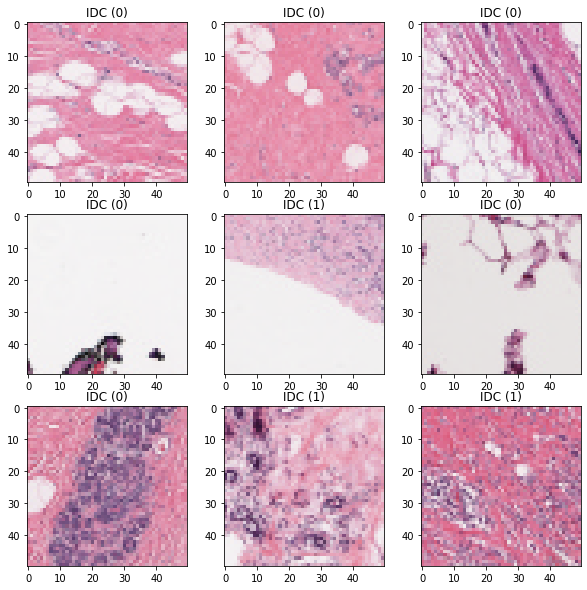

In [33]:
# evalutating model
from sklearn.metrics import classification_report, confusion_matrix

pred = model.predict(X_test2)

#Classification To check wether IDC or Not IDC
res = []
for prediction in pred:
    if(prediction > 0.5):
        res.append(1)
    else:
        res.append(0)

#Final Classification Report using Confusion Matrix
print(confusion_matrix(y_test2, res))
print(classification_report(y_test2, res))

plt.figure(figsize= (10,10))
ind = np.random.randint(0, len(pred), 9)
i=0
#The patient having IDC is represented by IDC 1 ,IDC 0 otherwise.
for loc in ind:
    plt.subplot(3,3,i+1)
    plt.xlabel(None)
    plt.title("IDC ({})".format(res[loc]))

    plt.imshow(X_test2[loc])
    i+=1

[[8468 1532]
 [2105 7895]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.82     10000
           1       0.84      0.79      0.81     10000

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000



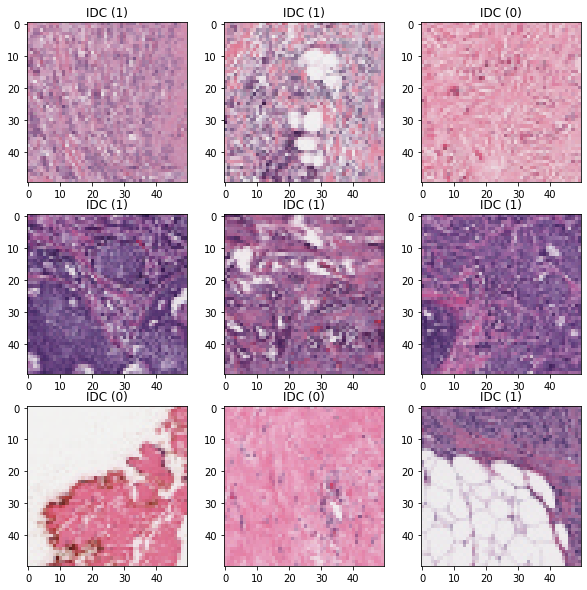

In [32]:
# evalutating model_dropout
from sklearn.metrics import classification_report, confusion_matrix

pred = model_dropout.predict(X_test2)

#Classification To check wether IDC or Not IDC
res = []
for prediction in pred:
    if(prediction > 0.5):
        res.append(1)
    else:
        res.append(0)

#Final Classification Report using Confusion Matrix
print(confusion_matrix(y_test2, res))
print(classification_report(y_test2, res))

plt.figure(figsize= (10,10))
ind = np.random.randint(0, len(pred), 9)
i=0
#The patient having IDC is represented by IDC 1 ,IDC 0 otherwise.
for loc in ind:
    plt.subplot(3,3,i+1)
    plt.xlabel(None)
    plt.title("IDC ({})".format(res[loc]))

    plt.imshow(X_test2[loc])
    i+=1

In [34]:
model.save('model/model_org')
model_dropout.save('model/model_dropout')

2022-02-13 18:13:09.367272: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/model_org/assets
INFO:tensorflow:Assets written to: model/model_dropout/assets
